# CS 505 Homework 06:  Transformers

## Problem Three 

See the problem one notebook for details on due date, submission, etc. 

As with problems one and two , there is an extensive tutorial section, followed by
some tasks at the end you need to complete. 

#### Full Disclosure:  This is based on  Rey Farhan's post:

(https://reyfarhan.com/posts/easy-gpt2-finetuning-huggingface/)


# Introduction

In this problem, we will learn about fine-tuning GPT2 using Hugging Face's [Transformers library](https://huggingface.co/transformers/) and PyTorch on raw data.

We start with a simplified script for fine-tuning GPT-2, and at the end, 
your task will be to modify this assignment on raw text of your choice (I have put Pride and Prejudice as an example below) and include 10 sample generations from your chosen text that you find interesting.


# Setup

In [1]:
!pip install transformers

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.8/126.8 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 150.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 213.2 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [8]:
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [1]:
import os
import time
import datetime
# from google.colab import drive

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt
# % matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /usr4/cs640/gaurav57/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
!nvidia-smi

Thu Dec 21 18:07:16 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           On  | 00000000:1A:00.0 Off |                    0 |
| N/A   53C    P0              77W / 300W |   9047MiB / 16384MiB |      0%   E. Process |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Create Training Set


In [3]:
# mount my Google Drive directory and access the training data located there
# gdrive_dir = '/content/gdrive/'
# data_dir = os.path.join(gdrive_dir, "'My Drive'")
# filename = 'prideAndPrejudice.txt'

# drive.mount(gdrive_dir, force_remount=True)


In [4]:
 filename = '/projectnb/cs505ws/students/gaurav57/prideAndPrejudice.txt'

In [5]:
# copy the data to the current Colab working directory
# !cp $data_dir/$filename .

In [6]:
f=open(filename)
docs=f.readlines()
docs=[b.strip() for b in docs]
docs[:5]

['It is a truth universally acknowledged, that a single man in possession of a good fortune, must be in want of a wife.',
 'However little known the feelings or views of such a man may be on his first entering a neighbourhood, this truth is so well fixed in the minds of the surrounding families, that he is considered the rightful property of some one or other of their daughters.',
 '"My dear Mr. Bennet," said his lady to him one day, "have you heard that Netherfield Park is let at last?"',
 'Mr. Bennet replied that he had not.',
 '"But it is," returned she; "for Mrs. Long has just been here, and she told me all about it."']

We need to get an idea of how long our training documents are.

I'm not going to use the same tokenizer as the GPT2 one, which is a [byte pair encoding tokenizer](https://blog.floydhub.com/tokenization-nlp/). Instead, I'm using a simple one just to get a rough understanding.

/scratch/3116117.1.academic-gpu/ipykernel_498254/3600140024.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(doc_lengths)


<Axes: ylabel='Density'>

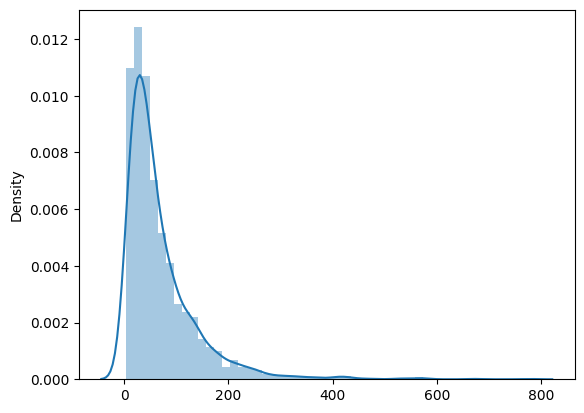

In [7]:
doc_lengths = []

for doc in docs:

    # get rough token count distribution
    tokens = nltk.word_tokenize(doc)

    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)

sns.distplot(doc_lengths)

In [8]:
# the max token length
len(doc_lengths[doc_lengths > 768])/len(doc_lengths)

0.0004847309743092584

In [11]:
np.average(doc_lengths)

69.48763936015511

Even though these token counts won't match up to the BPE tokenizer's, I'm confident that most lines will be fit under the 768 embedding size limit for the small GPT2 model.

# GPT2 Tokenizer

Although the defaults take care of this,I thought I'd show that you can specify some of the special tokens.

In [10]:
# Load the GPT tokenizer.
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-medium


In [12]:
print("The max model length is {} for this model, although the actual embedding size for GPT small is 768".format(tokenizer.model_max_length))
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))

The max model length is 1024 for this model, although the actual embedding size for GPT small is 768
The beginning of sequence token <|startoftext|> token has the id 50257
The end of sequence token <|endoftext|> has the id 50256
The padding token <|pad|> has the id 50258


# PyTorch Datasets & Dataloaders


GPT2 is a large model. Increasing the batch size above 2 has lead to out of memory problems. This can be mitigated by accumulating the gradients but that is out of scope here.

In [13]:
batch_size = 2

I'm using the standard PyTorch approach of loading data in using a [dataset class](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

I'm passing in the tokenizer as an argument but normally I would  instantiate it within the class.

In [14]:
class GPT2Dataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=768):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:

      encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx]

To understand how I've used the tokenizer, it's worth reading [the docs](https://huggingface.co/transformers/main_classes/tokenizer.html). I've wrapped each line in the bos and eos tokens.

Every tensor passed to the model should be the same length.

If the line is shorter than 768 tokens, it will be padded to a length of 768 using the padding token. In addition, an attention mask will be returned that needs to be passed to the model to tell it to ignore the padding tokens.

If the line is longer than 768 tokens, it will be truncated without the eos_token. This isn't a problem.

In [15]:
dataset = GPT2Dataset(docs, tokenizer, max_length=768)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

1,856 training samples
  207 validation samples


In [16]:
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order.
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# Finetune GPT2 Language Model

In [17]:
# I'm not really doing anything with the config buheret
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# instantiate the model
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [18]:
# some parameters I cooked up that work reasonably well

epochs = 5
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 100

In [19]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

/usr4/cs640/gaurav57/.local/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [20]:
# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = warmup_steps,
                                            num_training_steps = total_steps)

In [21]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [23]:
from tqdm import tqdm

In [24]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in tqdm(range(0, epochs)):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()

        outputs = model(  b_input_ids,
                          labels=b_labels,
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,
                                    top_k=50,
                                    max_length = 200,
                                    top_p=0.95,
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        with torch.no_grad():

            outputs  = model(b_input_ids,
#                            token_type_ids=None,
                             attention_mask = b_masks,
                            labels=b_labels)

            loss = outputs[0]

        batch_loss = loss.item()
        total_eval_loss += batch_loss

    avg_val_loss = total_eval_loss / len(validation_dataloader)

    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

  0%|          | 0/5 [00:00<?, ?it/s]


======== Epoch 1 / 5 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    928. Loss: 0.4344193637371063.   Elapsed: 0:00:19.
0:  bipartisan" and "but had never seen the face of either any of their party--therefore no doubt, we ought so to take it as dear as every lady had given to this family."


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    928. Loss: 0.241342231631279.   Elapsed: 0:00:37.
0:  increasingA he had not yet gained his sight of Lizzy's appearance when she spoke, because she saw her.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    928. Loss: 0.3199116289615631.   Elapsed: 0:00:53.
0: day"And there were several days before it was settled, Mr. Bingley, who was certainly in a slight degree satisfied, was looking forward to seeing Mrs. Bennet. She, like herself, must soon be seen to be of the greatest interest in the neighbourhood; and she looked forward to seeing Elizabeth from their place of residence--and even if she found him to have something which Miss Bingley was, she should like nothing more than a visitor from this neighbourhood. She seemed almost to feel satisfied with his presence--her mother, the most agreeable of the sisters, and the most natural, kind, and kindest and mostitiable of the daughters--and she really wished to see Mrs. Bennet, her brother, and the daughter with the most favourable eyes.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    928. Loss: 0.35124173760414124.   Elapsed: 0:01:10.
0:  Hang"My dear and dear, my dear, I have no time for this," said Charlotte, "but the moment you are gone, I trust you will be a little more comfortable in the library. Do not expect to leave him, but you will not be so lost to this library that you will soon be able to get acquainted with your son and his family. Do not expect to come into our room. You must be able to write down and follow your wife down as she is wandering with her children, and if you have never thought to write, perhaps you will knowump himself. He is a very pleasant man, and even a beautiful, very smart man. He will laugh his head off, he will be very angry, and he will never marry any of his children. But he is not happy, I am sure, nor do I think he is at all the point of it."


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of    928. Loss: 0.31730371713638306.   Elapsed: 0:01:27.
0:  foodsElizabeth and Kitty began walking towards Rosings; but though there was a pause, there was at the end of it a pause which marked the end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of    928. Loss: 0.16978195309638977.   Elapsed: 0:01:43.
0:  trail"There was a great deal to say before Mr. Bennet turned away from us."


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of    928. Loss: 0.2888268232345581.   Elapsed: 0:01:59.
0: intendThe whole country was then engaged in the execution of her master's plan; with an endeavour to increase the comfort and importance of her business, and increase her marketability, that she might have a right of employment in the fields of business which she might choose, in a more lively and lively society.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of    928. Loss: 0.3050519526004791.   Elapsed: 0:02:15.
0:  surroundElizabeth began his apology for his indifference on Monday.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of    928. Loss: 0.28032082319259644.   Elapsed: 0:02:31.
0:  reflex"I must think so, though Mr. Collins says he cannot have done more than he ought to."

  Average training loss: 0.51
  Training epoch took: 0:02:36

Running Validation...


 20%|██        | 1/5 [02:40<10:43, 160.77s/it]

  Validation Loss: 0.32
  Validation took: 0:00:05

======== Epoch 2 / 5 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    928. Loss: 0.0703025534749031.   Elapsed: 0:00:16.
0:  displayTheir carriage was hastened by the sound of some distant voice. Mrs. Gardiner, who had only heard from Lydia, said nothing, but gave her a smile which read:


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    928. Loss: 0.1618892401456833.   Elapsed: 0:00:32.
0:  pastor"This cannot be. It is a great deal of business."


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    928. Loss: 0.1355324536561966.   Elapsed: 0:00:47.
0:  illicitTheir aunt and mother were now gone with them home; and Miss Bennet's visit, she thought, might be of use to any woman.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    928. Loss: 0.45420631766319275.   Elapsed: 0:01:03.
0:  LiberationThe whole party soon came into conversation. Mr. Wickham began by talking of the prospect of the Lady's going away, and Elizabeth wondered why she was so easily invited home by Mr. Bingley. It was no longer a matter of the least importance to any lady of whom her husband was connected; she was assured, however, that she could not make her stay at Netherfield by night, and that she would return the next morning with a less desirable wife.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of    928. Loss: 0.4956209361553192.   Elapsed: 0:01:20.
0:  Nam"You must be quite right, my dear, that there is something of an advantage to this account. It shows that, in speaking to Lydia, you were familiar with Mr. Darcy's views--your friend's philosophy--your own. The kind of people we had first known in Hertfordshire at the assembly. I was convinced you of his being a very respectable man indeed. But it is impossible that the gentleman who presided over him should have known any such particulars as Mr. Darcy now says."


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of    928. Loss: 0.11431195586919785.   Elapsed: 0:01:36.
0: ION"But why _he_?"


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of    928. Loss: 0.22772693634033203.   Elapsed: 0:01:52.
0:  glimpseMr. Darcy continued to walk.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of    928. Loss: 0.1741788238286972.   Elapsed: 0:02:08.
0:  Laure"Indeed, indeed!" said Darcy; "I am perfectly certain it is not."


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of    928. Loss: 0.11126153916120529.   Elapsed: 0:02:23.
0: ism"Oh! yes--the gentleman is a very gentlemanlike man--Mr. Darcy may mention him to Mr. Bingley. I wish I could say that he is not but--he must be one of the youngest, most accomplished gentlemen ever to ever live."

  Average training loss: 0.30
  Training epoch took: 0:02:28

Running Validation...


 40%|████      | 2/5 [05:13<07:48, 156.23s/it]

  Validation Loss: 0.32
  Validation took: 0:00:05

======== Epoch 3 / 5 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    928. Loss: 0.4781046509742737.   Elapsed: 0:00:16.
0: oun"Why, yes, he did not. But we had no reason to fear his being in London. A gentleman and a stranger had come up to make him wait on Wickham with him at Hunsford the other day, and he was to go there in summer; and at Hunsford he met with a gentleman, Wickham, and we were in it. We parted; it was only a matter of time before he was gone."


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    928. Loss: 0.17903149127960205.   Elapsed: 0:00:32.
0:  election"I believe so very well you have. Mrs. Bennet's not very fond of me. She does not think too much of me for the compliment. I cannot think of her unless I call her Lady Catherine, I am sure I shall never esteem her more _like_ you."


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    928. Loss: 0.17828911542892456.   Elapsed: 0:00:48.
0:  crazy"Good Lord! I beg you will come. I am glad to oblig you."


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    928. Loss: 0.4151059091091156.   Elapsed: 0:01:03.
0:  bench"Yes--and how will Mrs. Bennet look when she sees your sister?"


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of    928. Loss: 0.10282772779464722.   Elapsed: 0:01:19.
0:  incorporated"I have just received a letter from him, and it is from him. I have never seen him before, for I am sure he wrote to me before any one else had. He has never met in person in a manner so vague, so unassailed by anything as the present."


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of    928. Loss: 0.19699344038963318.   Elapsed: 0:01:35.
0: PeterElizabeth's mind was engaged in an activity most easily defined by a smile; and, though her spirits were at a low, she saw that her words were passing through her head, because it was evident that she understood them; for, if it had not been the wish of the writer who meant it, and she was truly satisfied that, with such happy assurance, he should soon meet her in Hertfordshire. Mrs. Collins was now again so happy, and the happiest memories of both were now in her power. She had never felt a smile that suggested its being any kind of confirmation of any of her feelings.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of    928. Loss: 0.26847586035728455.   Elapsed: 0:01:52.
0: uringElizabeth could not but wonder. It was impossible that such a girl should ever come into the world, and her curiosity must be so indefinite as not to give Lydia the management of a fortune which she was determined to avoid.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of    928. Loss: 0.09133370220661163.   Elapsed: 0:02:07.
0:  reproductiveAs for herself, it is certain that she will at all endeavour to forget her cousin's name, and be thankful for the happiness she may receive from him in an occasional moment. But, in a respect to her situation, it is certain that she would not have thought it right to retain the right of distinguishing her father. Her father, however, had been of a very respectable family; and to lose a brother was a most frequent and frequent source of pleasure; though it would not be wise, however, to neglect it. He had much to do, and if he wished to separate himself from either of them, it would not be very difficult; and, moreover, his attachment had not been established in her.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of    928. Loss: 0.23650145530700684.   Elapsed: 0:02:24.
0:  zone"There could not exist a more agreeable county to give a ball. Mr. Collins might have had a very agreeable family; but I am convinced he should have had a very large fortune, and he might have had his share of pleasure in Hertfordshire."

  Average training loss: 0.25
  Training epoch took: 0:02:29

Running Validation...


 60%|██████    | 3/5 [07:47<05:10, 155.17s/it]

  Validation Loss: 0.33
  Validation took: 0:00:05

======== Epoch 4 / 5 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    928. Loss: 0.6384181976318359.   Elapsed: 0:00:16.
0:  commits"I can not be held to be in this room long. My mother and sisters both say they are very grieved at such a sight; and I can hardly help laughing aloud at the horror of what I have ever endured."


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    928. Loss: 0.20012055337429047.   Elapsed: 0:00:31.
0:  irony"Certainly," said he, "and it is certain that Mrs. Forster would like him; but there is reason to think that such a man would be a more sensible man than she is."


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    928. Loss: 0.09277410060167313.   Elapsed: 0:00:47.
0:  Sah"As I have often observed, he is certainly a most interesting, though not quite so handsome, young man. He is a fine, gentlemanlike man, with noble manners; but above all, of good breeding, people are very fond of him; and he has the reputation as the most valuable man in the world, which everybody can boast; and that is to say, nobody can have any regard to his accomplishments, and it is he who most wants Mr. Darcy's regard."


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    928. Loss: 0.21290268003940582.   Elapsed: 0:01:04.
0:  Bryan"I knew I should be ashamed of my own vulgarity," replied she, "but I could not help laughing at the very head of it, to make some money; and I am sure I have made some mistakes, and may even have wounded your own interest."


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of    928. Loss: 0.1295122653245926.   Elapsed: 0:01:20.
0:  spirits"She is now only sixteen."


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of    928. Loss: 0.25616350769996643.   Elapsed: 0:01:35.
0:  sees"No," said Wickham, "I do not pretend to be surprised."


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of    928. Loss: 0.12812726199626923.   Elapsed: 0:01:51.
0:  hungry"I know no such person," said Darcy, after a pause; "but it is a stranger."


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of    928. Loss: 0.3474457561969757.   Elapsed: 0:02:07.
0:  PT"They are going to go down to Ramsgate by themselves! It would be such a delicious scheme if we all worked together. Let Mr. Collins come and shoot as many foxhounds as he chooses; and then he would have nothing to shoot about."


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of    928. Loss: 0.1793249100446701.   Elapsed: 0:02:22.
0: ü"Lizzy," said Mrs. Bennet, "I have heard it, but that is a very strange notion which I had never heard before. Allow me to say, that the lady who does the honours of the house, Lady Catherine de Bourgh, had better not have been here."

  Average training loss: 0.20
  Training epoch took: 0:02:27

Running Validation...


 80%|████████  | 4/5 [10:20<02:34, 154.05s/it]

  Validation Loss: 0.35
  Validation took: 0:00:05

======== Epoch 5 / 5 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    928. Loss: 0.06076744571328163.   Elapsed: 0:00:16.
0: ruce"No, no--nay, let them be at home, and laugh and be silly all the time."


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    928. Loss: 0.14474354684352875.   Elapsed: 0:00:31.
0:  derivatives"I have been a long time in Hertfordshire, where I have been most fortunate. I have narrowly observed, and though I have not been able to obtain any good account of it, I have always observed, that the established forms of family living in most parts of the kingdom are not unguarded. The established forms of entertainment are few; they are confined only to the few most desirable neighbourhoods; the less desirable are neighbourhoods where the private economy is continually under frequent discussion, and where the preference of rank is maintained by good-natured and careful attention to the greater good of the neighbourhood. In such neighbourhoods as Longbourn and Lambton, where there is a predominance of family preference, it is unguarded. Those neighbourhoods most connected with society may, in general prefer a less regimented and less eccentric form of society; and to such neighbourhoods as Gracech

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    928. Loss: 0.11544941365718842.   Elapsed: 0:00:48.
0: "You cannot deny the compliment, Miss Eliza?"


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    928. Loss: 0.21109259128570557.   Elapsed: 0:01:04.
0:  remembering"If that is the case," replied he, "you must be severe on us. We will think no more of you; but I have a right to give you pain. You are intolerable. Human nature is the way with you."


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of    928. Loss: 0.26442426443099976.   Elapsed: 0:01:20.
0:  Sources"Miss Bennet Bennet," said his companion, "have you seen my master? Mr. Darcy will give you a good deal of particulars, too, on the particulars of a young man of small fortune, who had not many friends before him, but who was very fond of dancing."


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of    928. Loss: 0.18950004875659943.   Elapsed: 0:01:36.
0: ems"Do not you? He cannot comprehend my feeling that way. Nor does he understand the connection between us."


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of    928. Loss: 0.20090503990650177.   Elapsed: 0:01:52.
0: tz"Mr. Darcy knows the kind of girl you are."


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of    928. Loss: 0.08407702296972275.   Elapsed: 0:02:07.
0: matic"I have often observed that the more polished an eye for beauty, the better it will be for the income of the few, and the greater its attention will be for the advantage of all."


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of    928. Loss: 0.13563387095928192.   Elapsed: 0:02:23.
0:  synd"I do not want a ball. I want two. What do you ask?"

  Average training loss: 0.15
  Training epoch took: 0:02:28

Running Validation...


100%|██████████| 5/5 [12:52<00:00, 154.55s/it]

  Validation Loss: 0.39
  Validation took: 0:00:05

Training complete!
Total training took 0:12:53 (h:mm:ss)


Let's view the summary of the training process.

In [26]:
# Display floats with two decimal places.
pd.set_option('display.precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,0.51,0.32,0:02:36,0:00:05
2,0.30,0.32,0:02:28,0:00:05
3,0.25,0.33,0:02:29,0:00:05
4,0.20,0.35,0:02:27,0:00:05
5,0.15,0.39,0:02:28,0:00:05


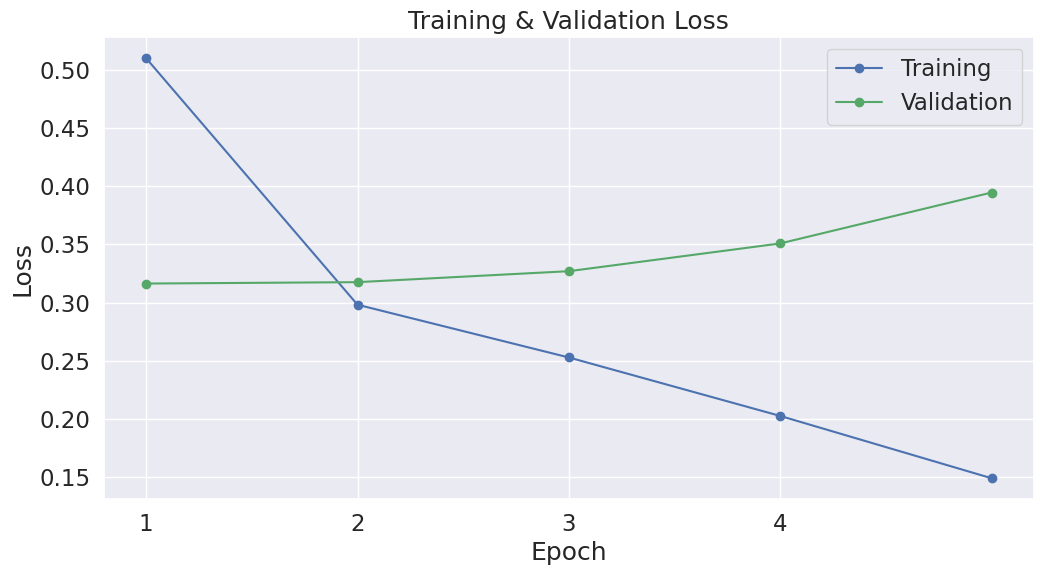

In [27]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# Display Model Info

In [28]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The GPT-2 model has 148 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (50259, 768)
transformer.wpe.weight                                   (1024, 768)

==== First Transformer ====

transformer.h.0.ln_1.weight                                   (768,)
transformer.h.0.ln_1.bias                                     (768,)
transformer.h.0.attn.c_attn.weight                       (768, 2304)
transformer.h.0.attn.c_attn.bias                             (2304,)
transformer.h.0.attn.c_proj.weight                        (768, 768)
transformer.h.0.attn.c_proj.bias                              (768,)
transformer.h.0.ln_2.weight                                   (768,)
transformer.h.0.ln_2.bias                                     (768,)
transformer.h.0.mlp.c_fc.weight                          (768, 3072)
transformer.h.0.mlp.c_fc.bias                                (3072,)
transformer.h.0.mlp.c_proj.weight                        (3072

# Saving & Loading Fine-Tuned Model


In [29]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Saving model to ./model_save/


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.json',
 './model_save/merges.txt',
 './model_save/added_tokens.json')

In [30]:
!ls -l --block-size=K ./model_save/

total 487547K
-rw-r--r-- 1 gaurav57 cs505wsta      1K Dec 21 16:23 added_tokens.json
-rw-r--r-- 1 gaurav57 cs505wsta      1K Dec 21 16:23 config.json
-rw-r--r-- 1 gaurav57 cs505wsta      1K Dec 21 16:23 generation_config.json
-rw-r--r-- 1 gaurav57 cs505wsta    446K Dec 21 16:23 merges.txt
-rw-r--r-- 1 gaurav57 cs505wsta 486114K Dec 21 16:23 model.safetensors
-rw-r--r-- 1 gaurav57 cs505wsta      1K Dec 21 16:23 special_tokens_map.json
-rw-r--r-- 1 gaurav57 cs505wsta      1K Dec 21 16:23 tokenizer_config.json
-rw-r--r-- 1 gaurav57 cs505wsta    976K Dec 21 16:23 vocab.json


In [31]:
!ls -l --block-size=M ./model_save/pytorch_model.bin

ls: cannot access './model_save/pytorch_model.bin': No such file or directory


In [ ]:
# Copy the model files to a directory in your Google Drive.
!cp -r ./model_save/ $data_dir

# # Load a trained model and vocabulary that you have fine-tuned
#model = GPT2LMHeadModel.from_pretrained(output_dir)
#tokenizer = GPT2Tokenizer.from_pretrained(output_dir)
#model.to(device)

# Generate Text

In [32]:
model.eval()

prompt = "<|startoftext|>"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(
                                generated,
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,
                                top_k=50,
                                max_length = 300,
                                top_p=0.95,
                                num_return_sequences=3
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[50257]], device='cuda:0')
0: "It may be a little," said Mrs. Bennet, "to name a few elegant names for a family within the kingdom; but for my part, I wish Mr. Collins would take the liberty of making as comfortable as possible the remarks and concerns of his patroness. I do not think there is any real advantage to having a lady like him. Lady Catherine is no such thing. Lady Lucas is a very accomplished lady, and I suppose she will be as happy as Lydia."


1: "I do not know whether you agree with me in that respect. But my situation in life, I should think, offers a certain security to _your_ affection. Consider your own situation. Your situation in life, I am convinced, offers a certain security to _your_ happiness. Consider also, from what passed before, that the want of principle, or of delicacy of manner, were to be so abominably reprehensible, as to make the young couple, and to rob them of their due respect. Consider also, from what passed before--that the want of princi

In [33]:
model.eval()

prompt = "<|startoftext|>"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(
                                generated,
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,
                                top_k=50,
                                max_length = 300,
                                top_p=0.95,
                                num_return_sequences=3
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[50257]], device='cuda:0')
0: "And, by and by," replied her mother, "your ladyship has given you credit as well as the truth, which is by no means so easy nor faulty as Wickham's. The country, I believe, is much in the way of it in some respects. The country is divided between rich and poor; but you, I am sure, do not pretend to care about either. It is the sort of thing that a young man like yourself should never care about. If I had my father's permission, I should certainly not care about it. I am so selfish as not to care about nothing at all. But if that young man, with five or six thousand a year, who comes in ten thousand a year, does not care about the country, how much we all like him, and what we think of him? When you give him a living, it gives you all the good sense in the world; but if he is only ten thousand a year, he cannot do much good either."


1: "Lizzy, you ought to go and see Jane," said her mother resentfully.


2: "But these are heavy misfortunes," said

### YOUR TURN!

These aren't bad at all! Now train the model on your chosen raw text that is roughly comparable in size to pride and prejudice.

There are two things you need to do:

- Draw a figure tracking the training and validation losses as in previous homeworks. 

- Print out some sample text from your chosen data and report 10 example generations that you think are interesting! Do your examples look like your training text?


> I'll be working on the Great Gatsby available in gutenberg ( https://www.gutenberg.org/ebooks/64317)

In [3]:
nltk.download('gutenberg')

[nltk_data] Downloading package gutenberg to
[nltk_data]     /usr4/cs640/gaurav57/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


True

In [19]:
import urllib.request
from nltk.tokenize import sent_tokenize
import nltk

# Make sure you have the 'punkt' tokenizer resource available
nltk.download('punkt')

# Open the text file from Project Gutenberg
text_file = urllib.request.urlopen("https://www.gutenberg.org/cache/epub/64317/pg64317.txt")

# Read and decode the text
text = text_file.read().decode('utf-8')
clean_text = text.replace('\r', '').replace('\n', ' ').replace('\t', ' ')
# Tokenize the text into sentences
docs = sent_tokenize(clean_text)

# Now 'sentences' is an array of sentences from the text
print(docs[:15])  # print the first 10 sentences to check

[nltk_data] Downloading package punkt to
[nltk_data]     /usr4/cs640/gaurav57/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['\ufeffThe Project Gutenberg eBook of The Great Gatsby      This ebook is for the use of anyone anywhere in the United States and most other parts of the world at no cost and with almost no restrictions whatsoever.', 'You may copy it, give it away or re-use it under the terms of the Project Gutenberg License included with this ebook or online at www.gutenberg.org.', 'If you are not located in the United States, you will have to check the laws of the country where you are located before using this eBook.', 'Title: The Great Gatsby   Author: F. Scott Fitzgerald  Release date: January 17, 2021 [eBook #64317]  Language: English    *** START OF THE PROJECT GUTENBERG EBOOK THE GREAT GATSBY ***        The Great Gatsby       by     F. Scott Fitzgerald                              Table of Contents  I II III IV V VI VII VIII IX                                 Once again                                   to                                  Zelda    Then wear the gold hat, if that will move her;

In [20]:
print(docs[10:11])

['And, after boasting this way of my tolerance, I come to the admission that it has a limit.']


In [6]:
# sentences

In [21]:
len(docs)

2560

/scratch/3127120.1.jchengroup-pub/ipykernel_507450/3600140024.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(doc_lengths)


<Axes: ylabel='Density'>

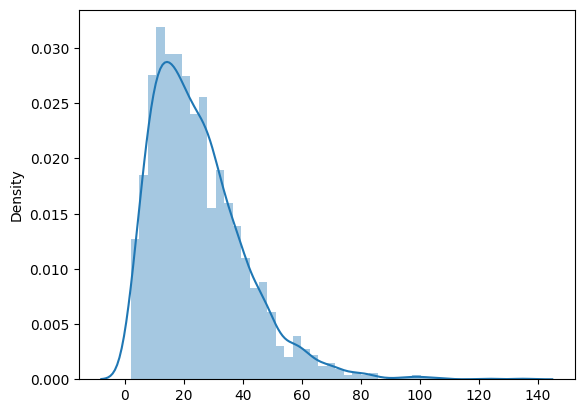

In [23]:
doc_lengths = []

for doc in docs:

    # get rough token count distribution
    tokens = nltk.word_tokenize(doc)

    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)

sns.distplot(doc_lengths)

In [24]:
# the max token length
len(doc_lengths[doc_lengths > 768])/len(doc_lengths)

0.0

In [25]:
np.average(doc_lengths)

24.989453125

In [26]:
#Considerably very short sentences as compared to Pride and Prejudice

In [27]:
# GPT2 Tokenizer
# Taking gpt2 and gpt2-medium takes a more computational time 

In [28]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>')

In [29]:
print("The max model length is {} for this model, although the actual embedding size for GPT small is 768".format(tokenizer.model_max_length))
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))

The max model length is 1024 for this model, although the actual embedding size for GPT small is 768
The beginning of sequence token <|startoftext|> token has the id 50257
The end of sequence token <|endoftext|> has the id 50256
The padding token <|pad|> has the id 50258


In [30]:
# PyTorch Datasets & Dataloaders

In [31]:
batch_size = 2

In [32]:
class GPT2Dataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=768):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:

      encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx]

In [33]:
dataset = GPT2Dataset(docs, tokenizer, max_length=768)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

2,304 training samples
  256 validation samples


In [34]:
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order.
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [35]:
# Finetune GPT2 Language Model

In [36]:
# I'm not really doing anything with the config buheret
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# instantiate the model
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [37]:
# learning_rate = 5e-3 # found this to give better sentences 

In [38]:
# some parameters I cooked up that work reasonably well

epochs = 7 
learning_rate = 5e-4 
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 100

In [39]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

/usr4/cs640/gaurav57/.local/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [40]:
# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = warmup_steps,
                                            num_training_steps = total_steps)

In [41]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [42]:
from tqdm import tqdm

In [43]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in tqdm(range(0, epochs)):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()

        outputs = model(  b_input_ids,
                          labels=b_labels,
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,
                                    top_k=50,
                                    max_length = 200,
                                    top_p=0.95,
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        with torch.no_grad():

            outputs  = model(b_input_ids,
#                            token_type_ids=None,
                             attention_mask = b_masks,
                            labels=b_labels)

            loss = outputs[0]

        batch_loss = loss.item()
        total_eval_loss += batch_loss

    avg_val_loss = total_eval_loss / len(validation_dataloader)

    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

  0%|          | 0/7 [00:00<?, ?it/s]


======== Epoch 1 / 7 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  1,152. Loss: 0.3235439360141754.   Elapsed: 0:00:18.
0:  bipartisan and



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  1,152. Loss: 0.12920372188091278.   Elapsed: 0:00:35.
0:  increasing“Come back to the city.” He asked in astonishment.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  1,152. Loss: 0.13178376853466034.   Elapsed: 0:00:51.
0: dayShe had one half-a-dozen carloads of white powder—it was a cigar or three with a, I thought, and I saw that I knew it.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  1,152. Loss: 0.20429769158363342.   Elapsed: 0:01:06.
0:  Hang“No,” he said with an uncertain nod.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  1,152. Loss: 0.05915180593729019.   Elapsed: 0:01:22.
0:  foodsI never had any trouble drawing a picture or anything, except for some one or two of Tom Baker.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  1,152. Loss: 0.22861233353614807.   Elapsed: 0:01:38.
0:  trailIt happened to me that she had always wanted to stay behind.”  “They had always been there,” she remarked with an incredulity in her eyes.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  1,152. Loss: 0.1372058242559433.   Elapsed: 0:01:54.
0: intendTo say I enjoyed myself pretty much and that I certainly enjoyed the music.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  1,152. Loss: 0.04415483400225639.   Elapsed: 0:02:10.
0:  surround“Did you just talk about that?”  “No.” demanded Catherine of course, but she wouldn’t answer.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  1,152. Loss: 0.06642195582389832.   Elapsed: 0:02:25.
0:  reflex“There’s another thing.”  “Oh, you’d been up all night.”  “You don’t know Miss Baker?”  “Do you?”  “Do you know her?”  I answered innocently.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  1,152. Loss: 0.11234036833047867.   Elapsed: 0:02:42.
0:  display“Oh, I can’t believe you wouldn’t do that,”  “Oh,’d like to.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  1,152. Loss: 0.14429333806037903.   Elapsed: 0:02:58.
0:  pastorIn June we drove over to Louisville to buy a few copies of Gatsby’s new book.

  Average training loss: 0.21
  Training epoch took: 0:03:06

Running Validation...


 14%|█▍        | 1/7 [03:12<19:13, 192.20s/it]

  Validation Loss: 0.13
  Validation took: 0:00:06

======== Epoch 2 / 7 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  1,152. Loss: 0.0918215662240982.   Elapsed: 0:00:16.
0:  illicit“But I’m glad to see him there.”  This is a good idea.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  1,152. Loss: 0.06442050635814667.   Elapsed: 0:00:31.
0:  Liberation“And how did you happen?” inquired Jordan innocently.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  1,152. Loss: 0.10335374623537064.   Elapsed: 0:00:47.
0:  Nam“If you’ll come back, Nick, then I’ll be your man on Long Island Island.”  A pause.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  1,152. Loss: 0.15056420862674713.   Elapsed: 0:01:03.
0: IONWhen he left the room, she exclaimed:  “Good night,” he said as he opened the door.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  1,152. Loss: 0.08567912876605988.   Elapsed: 0:01:19.
0:  glimpseThen he took her hand in his, and we both kissed—but I don’t know how he made it—not that I love him.”  “But you loved him.”  “I love him,” said Gatsby.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  1,152. Loss: 0.13228243589401245.   Elapsed: 0:01:35.
0:  LaureHe made a habit of saying hello to people whom he knew, for instance, and that would be all if he ever knew.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  1,152. Loss: 0.11065416038036346.   Elapsed: 0:01:51.
0: ismThere was a small party-table which had been made up, one in a small circular of cream, two towels, and a dressing-gasket.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  1,152. Loss: 0.06659610569477081.   Elapsed: 0:02:07.
0: ounHe knew we weren’t entirely content with that,” she said.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  1,152. Loss: 0.06075119227170944.   Elapsed: 0:02:22.
0:  election“Come on!” he shouted.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  1,152. Loss: 0.10974770784378052.   Elapsed: 0:02:38.
0:  crazy“What’s my name?”  “Anyhow, Myrtle Wilson.”  “How do I know your name?”  “Right about the name.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  1,152. Loss: 0.1914774775505066.   Elapsed: 0:02:54.
0:  bench“I was very glad to see him.”  “Oh!”  “You mean he’s getting killed?”  “He’s dead.”  “Does he?”  “Yes.”  “No, he’s dead.

  Average training loss: 0.11
  Training epoch took: 0:03:03

Running Validation...


 29%|██▊       | 2/7 [06:21<15:51, 190.39s/it]

  Validation Loss: 0.13
  Validation took: 0:00:06

======== Epoch 3 / 7 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  1,152. Loss: 0.020341766998171806.   Elapsed: 0:00:16.
0:  incorporated“What are you doing?”  “I’m all out of prac—”  So he turned his head and looked at me admiringly.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  1,152. Loss: 0.1572325974702835.   Elapsed: 0:00:32.
0: Peter“The idea was that if we were young we’d go into it and we’d be responsible to nobody.”  “Well, suppose somebody did.”  “I just meant we’d try and clean up the mess up.”  “It was a shame to waste the day.”  Tom Buchanan, who had no such facilities, had changed hands and died suddenly.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  1,152. Loss: 0.04640946164727211.   Elapsed: 0:00:48.
0: uring“You were a friend of hers,” she remarked contemptuously.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  1,152. Loss: 0.07182154804468155.   Elapsed: 0:01:04.
0:  reproductive“And what’s more, he used to speak to a man who couldn’t understand, even without a hint.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  1,152. Loss: 0.11257409304380417.   Elapsed: 0:01:20.
0:  zoneHe said that he knew she didn’t want to see him in the city.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  1,152. Loss: 0.04509647935628891.   Elapsed: 0:01:35.
0:  commits“Are we going to have fun?” she cried excitedly.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  1,152. Loss: 0.15667396783828735.   Elapsed: 0:01:51.
0:  irony she can be a man to me a little girl, it to it a girl her his� and she in the a young the he-a man her it me a white her  the girl to Mrs A group a he a ( and a he one he said it of Mrs all you mustn with any one that that  He- he her they it is they I G you young young it could one it in a three new a woman and we I a other up you may I  her ( G  � her all  it girl he must he a w    you        he she I it  to   the girl a m with  girl, young


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  1,152. Loss: 0.16262058913707733.   Elapsed: 0:02:09.
0:  SahShe said at Tom, and he came on the hot, if the night when the house and a little man.’t, and I said into the car I you and to the way I the dog to the eyes,’


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  1,152. Loss: 0.2890658378601074.   Elapsed: 0:02:26.
0:  BryanShe wasn the most suspicious here and he came in his house, and the date being a man—


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  1,152. Loss: 0.1805126667022705.   Elapsed: 0:02:42.
0:  spiritsI had was said and the rest.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  1,152. Loss: 0.048494305461645126.   Elapsed: 0:02:58.
0:  seesIt was much the dark eyes.”  “I’d you know what they want to be full, when I’d be in the garage, and you had a white—’s going back again, and when I’s never have left her face—the head down a minute and an office.”  “Where was like an individual lawn.

  Average training loss: 0.15
  Training epoch took: 0:03:07

Running Validation...


 43%|████▎     | 3/7 [09:34<12:46, 191.56s/it]

  Validation Loss: 0.18
  Validation took: 0:00:06

======== Epoch 4 / 7 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  1,152. Loss: 0.157671719789505.   Elapsed: 0:00:16.
0:  hungryThey stood there two days with an hour later it looked like the old Metropostoffers from Central Park, alone, in the West Indies, out the dark fields, and when I thought she came East.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  1,152. Loss: 0.07430312037467957.   Elapsed: 0:00:32.
0:  PT“What we’d do without that?”  He asked.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  1,152. Loss: 0.08759625256061554.   Elapsed: 0:00:47.
0: üGatz’s face fell in his chair.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  1,152. Loss: 0.10884486138820648.   Elapsed: 0:01:03.
0: ruce“Please let’s get him out.”  “I knew that I called Tom.”  “It was an old clock,” he said calmly, as we shook up the electric trains.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  1,152. Loss: 0.03669263422489166.   Elapsed: 0:01:19.
0:  derivativesThe room was large and gigantic—it was, after all, a place where only light is permitted.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  1,152. Loss: 0.11601942032575607.   Elapsed: 0:01:35.
0: “Your host’s dog” called Daisy.”  “No, but Mr.”  “I couldn’t.”  We’re both thanking Mrs.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  1,152. Loss: 0.11778542399406433.   Elapsed: 0:01:51.
0:  rememberingI wondered what you’d been doing that summer.”  “You’re crazy about me?” demanded Tom crossed from the phone.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  1,152. Loss: 0.10692338645458221.   Elapsed: 0:02:07.
0:  Sources“Not even half a dozen.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  1,152. Loss: 0.1130228191614151.   Elapsed: 0:02:23.
0: emsThen she kissed Gatsby, kissed him again, and took his wallet.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  1,152. Loss: 0.11701454222202301.   Elapsed: 0:02:38.
0: tz“Well, you got me.” He went on nervously.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  1,152. Loss: 0.05287550017237663.   Elapsed: 0:02:54.
0: matic“I think he killed her, Nick, but you must have been mad about him for a long time to get such a positive impression.”  “You must have been mad about him.”  “Oh, Nick.”  “Not mad,” said Mrs. Wilson.

  Average training loss: 0.10
  Training epoch took: 0:03:03

Running Validation...


 57%|█████▋    | 4/7 [12:43<09:31, 190.65s/it]

  Validation Loss: 0.16
  Validation took: 0:00:06

======== Epoch 5 / 7 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  1,152. Loss: 0.07327549159526825.   Elapsed: 0:00:16.
0:  syndThey weren’t happy.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  1,152. Loss: 0.102940134704113.   Elapsed: 0:00:31.
0:  gam“And I never loved Tom and you never loved him any more.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  1,152. Loss: 0.03884144872426987.   Elapsed: 0:00:47.
0:  injury“It’s the funniest thing that anyhow.”  “It looks wonderful on you!”  “It was a beautiful thing,” said Gatsby, glancing at him with tense gaiety.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  1,152. Loss: 0.0495293028652668.   Elapsed: 0:01:03.
0: azaI was at the station directly behind that, approached by four men in white, and in turn drove a hundred yards toward the front door.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  1,152. Loss: 0.0559210442006588.   Elapsed: 0:01:19.
0:  membraneShe smiled.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  1,152. Loss: 0.07643410563468933.   Elapsed: 0:01:35.
0: ijingThey were the only people I knew, and their whole statement was an affront to my own idea of being a politician and an affront to the common store of life, a statement that had no consciousness of being true.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  1,152. Loss: 0.04775267466902733.   Elapsed: 0:01:51.
0:  cast“I won’t telephone for a minute.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  1,152. Loss: 0.051484595984220505.   Elapsed: 0:02:06.
0:  purchThe day had passed beyond credibility, and Myrtle Wilson caught something in it that hadn’t occurred to her before, and suddenly Tom Buchanan yawned audibly at her as if he were a ghostly celebrity.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  1,152. Loss: 0.06399679183959961.   Elapsed: 0:02:22.
0:  shoulders“I don’t think she talks, I don’t think she talks very much, and it’s a big dog, and everybody ought to talk to her.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  1,152. Loss: 0.08352766931056976.   Elapsed: 0:02:38.
0:  built“The one you found was … Meyer Wolfshiem,” I told you.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  1,152. Loss: 0.06202688440680504.   Elapsed: 0:02:54.
0:  openlyI had to ask you a question, but I couldn’t answer your question.

  Average training loss: 0.07
  Training epoch took: 0:03:02

Running Validation...


 71%|███████▏  | 5/7 [15:52<06:19, 189.89s/it]

  Validation Loss: 0.17
  Validation took: 0:00:06

======== Epoch 6 / 7 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  1,152. Loss: 0.06407402455806732.   Elapsed: 0:00:16.
0:  halted“I’m delighted that you’re leaving.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  1,152. Loss: 0.05714773014187813.   Elapsed: 0:00:31.
0:  Nik“Some big movies.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  1,152. Loss: 0.02177143655717373.   Elapsed: 0:00:47.
0:  tin“And what about that?”  The officer in green took a step toward her and, opening it again, looked at her incredulously.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  1,152. Loss: 0.03507759049534798.   Elapsed: 0:01:03.
0:  clinicalIt was when he realized just why Jordan Baker had been bothering him so much.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  1,152. Loss: 0.05398010462522507.   Elapsed: 0:01:18.
0: lections“But you’re going to wait here and see what I say.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  1,152. Loss: 0.06563635915517807.   Elapsed: 0:01:34.
0: els“I think they’ll trace your car to the city,” I remarked.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  1,152. Loss: 0.0482340082526207.   Elapsed: 0:01:50.
0: lab“How’d you happen to happen to him?”  “I tried to think of it.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  1,152. Loss: 0.0446595698595047.   Elapsed: 0:02:06.
0:  triple“I’ve got a man in England who buys me clothes.”  He opened and closed the door, looking at me keenly.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  1,152. Loss: 0.08034232258796692.   Elapsed: 0:02:22.
0: 220“And what’s more, you come over often—to give that impression, is to feel superior to people.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  1,152. Loss: 0.06346844881772995.   Elapsed: 0:02:37.
0:  See“We haven’t met for many years.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  1,152. Loss: 0.05496757850050926.   Elapsed: 0:02:53.
0: @@“You live in California,” murmured Mrs. McKee.

  Average training loss: 0.05
  Training epoch took: 0:03:01

Running Validation...


 86%|████████▌ | 6/7 [18:59<03:09, 189.15s/it]

  Validation Loss: 0.19
  Validation took: 0:00:06

======== Epoch 7 / 7 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  1,152. Loss: 0.03912794217467308.   Elapsed: 0:00:16.
0:  host“I’m fifty.”  “I think I was just thirty,” admitted Daisy, her voice glowing and lovely.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  1,152. Loss: 0.042014189064502716.   Elapsed: 0:00:31.
0: roleHe said: ‘All right,’ we’re going to town.”  “It’s just a—”  “a small town.”  “It’s small town,” insisted Jordan, almost surprised at its size.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  1,152. Loss: 0.026697944849729538.   Elapsed: 0:00:48.
0: iac“She used to be able to understand.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  1,152. Loss: 0.05866708979010582.   Elapsed: 0:01:03.
0:  LD“This is an old timetable,” she whispered.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  1,152. Loss: 0.02421637438237667.   Elapsed: 0:01:19.
0:  Listen“He reads deep books,” repeated Gatsby.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  1,152. Loss: 0.02403935417532921.   Elapsed: 0:01:35.
0:  dy“I didn’t make the cut.”  “Why don’t you say you loved Nick?”  “I was just thinking I loved her too.”  He broke off.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  1,152. Loss: 0.050411392003297806.   Elapsed: 0:01:51.
0:  DomesticHe stopped at a table and took off his glasses.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  1,152. Loss: 0.049992065876722336.   Elapsed: 0:02:06.
0:  beneficiariesThey’ll all go to bed.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  1,152. Loss: 0.047483887523412704.   Elapsed: 0:02:22.
0:  Title“It’s a bona-fide piece of printed matter,” I said.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  1,152. Loss: 0.03598104044795036.   Elapsed: 0:02:38.
0:  μYou can’t live forever; you can’t live forever.”  He shook his head.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  1,152. Loss: 0.015882272273302078.   Elapsed: 0:02:54.
0:  selling“Why, I thought, isn’t that any police dog?

  Average training loss: 0.04
  Training epoch took: 0:03:02

Running Validation...


100%|██████████| 7/7 [22:07<00:00, 189.70s/it]

  Validation Loss: 0.21
  Validation took: 0:00:06

Training complete!
Total training took 0:22:08 (h:mm:ss)


In [45]:
# Display floats with two decimal places.
pd.set_option('display.precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,0.21,0.13,0:03:06,0:00:06
2,0.11,0.13,0:03:03,0:00:06
3,0.15,0.18,0:03:07,0:00:06
4,0.10,0.16,0:03:03,0:00:06
5,0.07,0.17,0:03:02,0:00:06
6,0.05,0.19,0:03:01,0:00:06
7,0.04,0.21,0:03:02,0:00:06


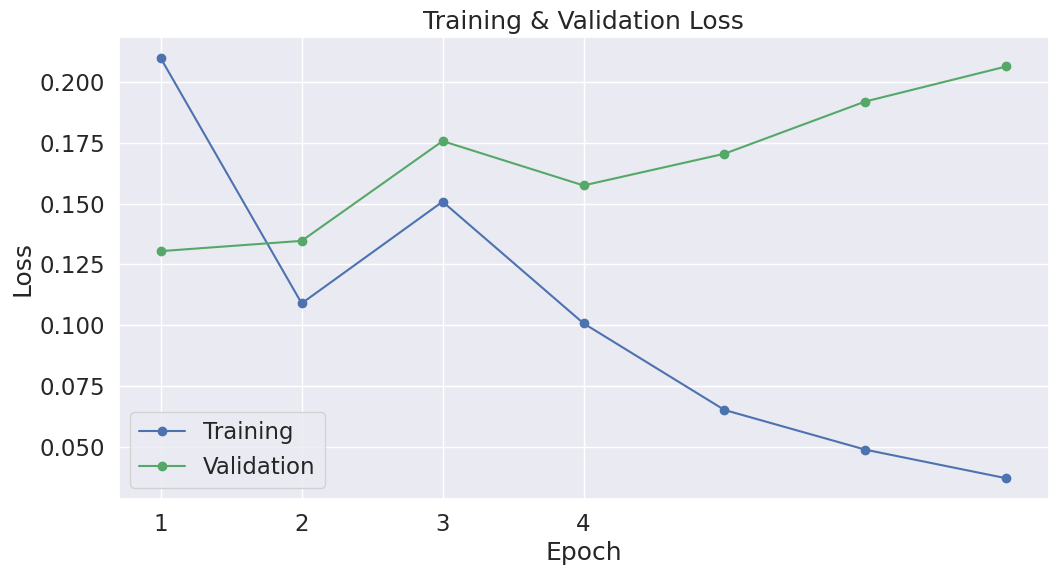

In [46]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [47]:
# Display Model Info

In [48]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The GPT-2 model has 148 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (50259, 768)
transformer.wpe.weight                                   (1024, 768)

==== First Transformer ====

transformer.h.0.ln_1.weight                                   (768,)
transformer.h.0.ln_1.bias                                     (768,)
transformer.h.0.attn.c_attn.weight                       (768, 2304)
transformer.h.0.attn.c_attn.bias                             (2304,)
transformer.h.0.attn.c_proj.weight                        (768, 768)
transformer.h.0.attn.c_proj.bias                              (768,)
transformer.h.0.ln_2.weight                                   (768,)
transformer.h.0.ln_2.bias                                     (768,)
transformer.h.0.mlp.c_fc.weight                          (768, 3072)
transformer.h.0.mlp.c_fc.bias                                (3072,)
transformer.h.0.mlp.c_proj.weight                        (3072

In [49]:
# Saving & Loading Fine-Tuned Model

In [50]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))

Saving model to ./model_save/


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.json',
 './model_save/merges.txt',
 './model_save/added_tokens.json')

In [51]:
!ls -l --block-size=K ./model_save/

total 487547K
-rw-r--r-- 1 gaurav57 cs505wsta      1K Dec 21 19:12 added_tokens.json
-rw-r--r-- 1 gaurav57 cs505wsta      1K Dec 21 19:12 config.json
-rw-r--r-- 1 gaurav57 cs505wsta      1K Dec 21 19:12 generation_config.json
-rw-r--r-- 1 gaurav57 cs505wsta    446K Dec 21 19:12 merges.txt
-rw-r--r-- 1 gaurav57 cs505wsta 486114K Dec 21 19:12 model.safetensors
-rw-r--r-- 1 gaurav57 cs505wsta      1K Dec 21 19:12 special_tokens_map.json
-rw-r--r-- 1 gaurav57 cs505wsta      1K Dec 21 19:12 tokenizer_config.json
-rw-r--r-- 1 gaurav57 cs505wsta    976K Dec 21 19:12 vocab.json


In [52]:
# Generate Text

In [53]:
model.eval()

prompt = "<|startoftext|>"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(
                                generated,
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,
                                top_k=50,
                                max_length = 300,
                                top_p=0.95,
                                num_return_sequences=3
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[50257]], device='cuda:0')
0: “You ought to have something to drink.”  “I almost made a mistake.


1: I was thirty.”  Before I could reply that I had dined with a girl of about my age, a phrase began to beat in my ears and my mouth began to dry.


2: “In the ditch beside the road, if you want to go to take a plunge in the swimming pool,” he suggested.




In [54]:
model.eval()

prompt = "<|startoftext|>"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(
                                generated,
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,
                                top_k=50,
                                max_length = 300,
                                top_p=0.95,
                                num_return_sequences=3
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[50257]], device='cuda:0')
0: “You sounded well enough on the phone.”  “Well, we were almost the last tonight, didn’t we?”  I nodded.


1: The following sentence, with active links to, or other immediate access to, the full Project Gutenberg™ License must appear prominently whenever any copy of a Project Gutenberg™ work (any work on which the phrase “Project Gutenberg” appears, or with which the phrase “Project Gutenberg” is associated) is accessed, displayed, performed, viewed, copied or distributed:        Project Gutenberg™          works.


2: “It must be a madman.”  “He’s mad!”  “Yes … Yes … Yes … Yes … Yes … there’s nothing …  He looked at Tom and then back at me, realizing that he wanted nothing less of Daisy than that she should be less of a thing and a thing.




In [55]:
model.eval()

prompt = "<|startoftext|>"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(
                                generated,
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,
                                top_k=50,
                                max_length = 300,
                                top_p=0.95,
                                num_return_sequences=3
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[50257]], device='cuda:0')
0: It was a gesture of farewell, a gesture that had belonged to Montenegro for five years and now it was an appropriate tribute for all of us.


1: And I believe he has a large future in front of him, which he hardly knows.


2: The porch was full of cheerful sun, bright with the fresh faces of those who came in from his front door.




In [56]:
model.eval()

prompt = "<|startoftext|>"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(
                                generated,
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,
                                top_k=50,
                                max_length = 300,
                                top_p=0.95,
                                num_return_sequences=3
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[50257]], device='cuda:0')
0: “She’s going to stay there till the day after tomorrow, and then we’ve run out of the house and we’ll go upstairs to have the evening—”  Tom’s words have always seemed unnaturally loud across the garden.


1: I wanted to see her and hear her voice, but her voice was muffled in the ear.


2: “There’s some bad trouble here,” said Gatsby.




In [58]:
model.eval()

prompt = "<|startoftext|>"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(
                                generated,
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,
                                top_k=50,
                                max_length = 200,
                                top_p=0.95,
                                num_return_sequences=10
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[50257]], device='cuda:0')
0: “They’ll never stop coming.”  “Never.” Tom’s face pressed against my shoulder, so I told him he must know something about me, and he knew that I lied.


1: Then there was another man in the car.


2: “I suppose he knew what he’d got to do.”  “What did he say to Wilson that afternoon?”  “Wilson wouldn’t consider it—Wilson wouldn’t consider it.


3: “We oughtn’t to let everything alone,” he muttered, “but we can’t—” He was saying it with a laugh, “but I’ve got to tell you right now.”  “And what?” Tom and Miss Baker tried to laugh, but her laughter was interrupted by the owl-eyed man’s face.


4: “They’re—”  “You’re crazy!” he exploded.


5: It was a yellow car.


6: That dog, a bitch, was sitting on my shoulder and chewing on my shoulder, as though it were a puppy.


7: “I told him.


8: She didn’t answer.


9: I don’t think that Mr. Gatsby bought a garage, for he had no real idea of the great rooms that floor.




In [59]:
model.eval()

prompt = "<|startoftext|>"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(
                                generated,
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,
                                top_k=50,
                                max_length = 500,
                                top_p=0.99,
                                num_return_sequences=10
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[50257]], device='cuda:0')
0: 1.E.6.


1: “Yes.”  “What—how could they possibly love each other?”  “You’ve been with me for two years,” Michaelis assured him.


2: He was so sick I almost fainted and Michaelis was so sick I could hardly fail an A.D.”  “All right, old sport.”  “I said right away.”  “Oh, you take Nick’s coupé to town.” I said lightly.


3: “What I called up about is—why—how long have you been married, George?


4: For all I knew he was going to rob the house on the strength of his position.


5: “He was just a young man,” she said wanly, “but I’m pretty sure he’d start at the Coney Island or something.


6: “Yes … Well, suppose we don’t go to town any more?” asked Jordan.


7: I didn’t mean to interrupt your lunch, but rather, rather, as we all went up in the hydroplane, I gave the impression that we’d been running around a thing all too much.


8: It was Mr. Buchanan who represented a deplorably small town in a far off from the Ohio, and perhaps he had some defi

Interesting samples colected 
1. “There’s some bad trouble here,” said Gatsby.
2. “She’s going to stay there till the day after tomorrow, and then we’ve run out of the house and we’ll go upstairs to have the evening—”  Tom’s words have always seemed unnaturally loud across the garden.
3. The porch was full of cheerful sun, bright with the fresh faces of those who came in from his front door.
4. It was a gesture of farewell, a gesture that had belonged to Montenegro for five years and now it was an appropriate tribute for all of us.
5. It must be a madman.”  “He’s mad!”  “Yes … Yes … Yes … Yes … Yes … there’s nothing …  He looked at Tom and then back at me, realizing that he wanted nothing less of Daisy than that she should be less of a thing and a thing.
6. The following sentence, with active links to, or other immediate access to, the full Project Gutenberg™ License must appear prominently whenever any copy of a Project Gutenberg™ work (any work on which the phrase “Project Gutenberg” appears, or with which the phrase “Project Gutenberg” is associated) is accessed, displayed, performed, viewed, copied or distributed:        Project Gutenberg™          works.
7. “In the ditch beside the road, if you want to go to take a plunge in the swimming pool,” he suggested.
8. That dog, a bitch, was sitting on my shoulder and chewing on my shoulder, as though it were a puppy.
9. “They’ll never stop coming.”  “Never.” Tom’s face pressed against my shoulder, so I told him he must know something about me, and he knew that I lied.
10. For all I knew he was going to rob the house on the strength of his position.

The first 4 sentences and the last 2 sentences are perfectly normal that seem like they are taken from the original text 

The 5th sentence has one too many repeating "Yes"

The 6th sentence is interesting because it includes “Project Gutenberg” which was present in the initial part of meta-data in the file. This shows that it needs to be removed. 

The 7th and 8th sentences are funny!